<a href="https://colab.research.google.com/github/johanstevenbejarano/Teoria-de-Aprendizaje-Maquina/blob/main/Parcial_1_TAM_2025-1/notebooks/RandomForestRegressor_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis del Modelo RandomForestRegressor  

---

## Introducción

Este notebook presenta un análisis detallado y riguroso del modelo de regresión basado en **Random Forest** aplicado al conjunto de datos Ames Housing. El objetivo es construir, evaluar y optimizar este modelo para predecir el valor de las viviendas, mediante un flujo completo que incluye:

- Carga y preparación de datos preprocesados y escalados.  
- Entrenamiento del modelo base con hiperparámetros por defecto.  
- Validación cruzada para evaluar estabilidad y generalización.  
- Diagnóstico estadístico y visual de los residuos para validar supuestos del modelo.  
- Análisis de importancia de características para interpretar el modelo.  
- Optimización de hiperparámetros utilizando técnicas avanzadas de búsqueda.  
- Evaluación comparativa del modelo ajustado frente al modelo base.  
- Visualizaciones clave como curva de aprendizaje, mapas de calor de sensibilidad y gráficos de predicción vs. valor real.  
- Guardado y descarga organizada de resultados y modelos para facilitar la reproducibilidad.

Este análisis está orientado a obtener un entendimiento profundo del desempeño del RandomForestRegressor y maximizar su potencial predictivo, así como a aportar claridad interpretativa para futuras mejoras o aplicaciones.

---

In [ ]:
# === CLONAR EL REPOSITORIO Y LISTAR SU CONTENIDO ===

# Clona el repositorio desde GitHub si no se ha hecho previamente.
# Esto permite acceder a los notebooks, datos y estructuras organizadas del proyecto.
!git clone https://github.com/johanstevenbejarano/Teoria-de-Aprendizaje-Maquina.git



# Lista el contenido del directorio del parcial dentro del repositorio clonado
# para confirmar que la estructura y carpeta 'data' existen correctamente.
!ls /content/Teoria-de-Aprendizaje-Maquina/Parcial_1_TAM_2025-1

Cloning into 'Teoria-de-Aprendizaje-Maquina'...
remote: Enumerating objects: 450, done.
remote: Counting objects: 100% (157/157), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 450 (delta 89), reused 75 (delta 30), pack-reused 293 (from 1)
Receiving objects: 100% (450/450), 18.31 MiB | 13.33 MiB/s, done.
Resolving deltas: 100% (270/270), done.
dashboard  notebooks	  README.md	    resultados
data	   parte_teorica  requirements.txt


In [ ]:


!ls /content/Teoria-de-Aprendizaje-Maquina

'Ejercicios TAM_2025-1'   Parcial_1_TAM_2025-1	 README.md


In [ ]:
# === IMPORTACIÓN DE LIBRERÍAS Y CAMBIO DE DIRECTORIO ===

import os      # Para manipular rutas de archivos y cambiar directorios
import joblib  # Para cargar archivos serializados (como los .pkl que contienen los datos escalados)

# Cambia al directorio principal del proyecto clonado para que todas las rutas relativas sean válidas.
os.chdir('/content/Teoria-de-Aprendizaje-Maquina/Parcial_1_TAM_2025-1')

# Define la ruta al archivo que contiene los datos ya preprocesados, escalados y divididos.
data_path = 'data/train_test_scaled.pkl'

# Verifica que el archivo exista antes de intentar cargarlo, y lanza un error claro si no se encuentra.
if not os.path.exists(data_path):
    raise FileNotFoundError(f"No se encontró el archivo esperado en: {data_path}")

In [ ]:

# === CARGA DE LOS DATOS PROCESADOS ===

# Carga el archivo .pkl que contiene los cuatro objetos: X_train_scaled, X_test_scaled, y_train, y_test
# Estos datos fueron escalados y divididos previamente en el notebook de preprocesamiento.
X_train_scaled, X_test_scaled, y_train, y_test = joblib.load(data_path)

# Confirmación visual de que la carga fue exitosa.
print("Datos cargados correctamente.")

%cd /content/Teoria-de-Aprendizaje-Maquina/Parcial_1_TAM_2025-1

Datos cargados correctamente.
/content


In [ ]:
# === IMPORTACIÓN DE LIBRERÍAS Y DEFINICIÓN DE MÉTRICAS PERSONALIZADAS ===

# ================================================================
#  IMPORTACIONES COMPLETAS – ESTUDIO DE REGRESORES AMES HOUSING
# ================================================================
!pip install scikit-optimize

# ============================
#  Utilidades generales
# ============================
import numpy as np
import pandas as pd
import time
import os
import warnings
warnings.filterwarnings("ignore")  # Opcional: suprime warnings en notebooks

# ============================
#  Modelos de regresión
# ============================
from sklearn.linear_model import (
    LinearRegression,
    Lasso, LassoCV,
    ElasticNet, ElasticNetCV,
    SGDRegressor,
    BayesianRidge
)
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR
from sklearn.model_selection import learning_curve
# Importaciones necesarias desde scikit-optimize
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from IPython.display import display

# ============================
#  Validación y búsqueda
# ============================
from sklearn.model_selection import (
    KFold,
    GridSearchCV,
    RandomizedSearchCV,
    learning_curve,
    cross_validate,
    cross_val_predict
)

# ============================
#  Métricas y scoring
# ============================
from sklearn.metrics import (
    mean_absolute_error,       # MAE
    mean_squared_error,        # MSE
    r2_score,                  # R²
    mean_absolute_percentage_error,  # MAPE
    make_scorer                # Para definir MAPE como scorer
)

# ============================
# Diagnóstico estadístico
# ============================
from scipy.stats import shapiro, kurtosis, skew
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# ============================
#  Visualización
# ============================
import matplotlib.pyplot as plt
import scipy.stats as stats  # necesario para pruebas estadísticas

import seaborn as sns

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.3 MB/s eta 0:00:00


In [ ]:
# === DEFINICIÓN DE MÉTRICA PERSONALIZADA: MAPE ===

# MAPE no está directamente disponible en sklearn, por lo que se define manualmente.
# Esta métrica mide el error absoluto medio en porcentaje, útil para interpretar desviaciones relativas.

def mean_absolute_percentage_error(y_true, y_pred):
    # Reemplaza ceros en y_true para evitar divisiones por cero (buena práctica numérica)
    y_true = np.where(y_true == 0, np.finfo(float).eps, y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Se integra la función MAPE a sklearn como un scorer compatible con cross_validate
# Se indica que un menor valor es mejor (greater_is_better=False)
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [ ]:
# === DEFINICIÓN DEL ESQUEMA DE VALIDACIÓN CRUZADA ===

# Se utiliza validación cruzada estratificada con 5 divisiones (folds)
# shuffle=True mezcla los datos antes de dividirlos (buena práctica)
# random_state permite reproducibilidad
cv = KFold(n_splits=5, shuffle=True, random_state=42)


# === DEFINICIÓN DE MÉTRICAS DE EVALUACIÓN PARA TODOS LOS MODELOS ===

# Las métricas estándar (MAE y MSE) son negativas en sklearn por convención (porque se busca minimizar)
# R² se mantiene tal cual
# MAPE se incluye como scorer personalizado
scoring = {
    'MAE': 'neg_mean_absolute_error',
    'MSE': 'neg_mean_squared_error',
    'R2': 'r2',
    'MAPE': mape_scorer
}

In [ ]:
modelos = {
    "LinearRegression": LinearRegression(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "SGDRegressor": SGDRegressor(max_iter=1000, tol=1e-3),
    "BayesianRidge": BayesianRidge(),
    "KernelRidge": KernelRidge(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "GaussianProcess": GaussianProcessRegressor(),
    "SVR": SVR()
}

In [ ]:
def evaluar_modelo_cv(nombre_modelo, modelo, X, y, cv, scoring, guardar_en=None):
    """
    Evalúa un modelo usando validación cruzada fold a fold,
    genera un DataFrame con resultados detallados y opcionalmente guarda el CSV.
    Ahora incluye una fila final 'Promedio' claramente etiquetada.
    """

    # Evaluación con validación cruzada
    resultados = cross_validate(
        estimator=modelo,
        X=X,
        y=y,
        cv=cv,
        scoring=scoring,
        return_train_score=False,
        n_jobs=-1
    )

    # Crear DataFrame por fold
    df_resultados = pd.DataFrame({
        "Fold": np.arange(1, cv.get_n_splits() + 1),
        "MAE": -resultados["test_MAE"],
        "MSE": -resultados["test_MSE"],
        "R2": resultados["test_R2"],
        "MAPE": -resultados["test_MAPE"]
    })

    # Fila promedio con etiqueta explícita
    promedio = df_resultados.mean(numeric_only=True)
    promedio["Fold"] = "Promedio"

    # Añadir al DataFrame
    df_resultados = pd.concat([df_resultados, pd.DataFrame([promedio])], ignore_index=True)

    # Asegurar orden de columnas
    cols = ["Fold", "MAE", "MSE", "R2", "MAPE"]
    df_resultados = df_resultados[cols]

    # Guardar si se indica
    if guardar_en:
        os.makedirs(os.path.dirname(guardar_en), exist_ok=True)
        df_resultados.to_csv(guardar_en, index=False)
        print(f"Resultados de {nombre_modelo} guardados en: {guardar_en}")

    return df_resultados




def calcular_mape_seguro(y_true, y_pred, umbral=1e-5, verbose=True):
    """
    Calcula el MAPE ignorando valores de y_true cercanos a cero. Devuelve el MAPE (%) y el número de observaciones usadas.

    Parámetros:
    ----------
    y_true : array-like
        Valores reales en escala original.

    y_pred : array-like
        Valores predichos en escala original.

    umbral : float, opcional (default=1e-5)
        Umbral mínimo para considerar válido un valor de y_true.

    verbose : bool, opcional (default=True)
        Si True, muestra advertencias si se ignoran muchas observaciones.

    Retorna:
    -------
    mape : float
        MAPE en porcentaje (%)

    n_utilizadas : int
        Número de observaciones válidas utilizadas en el cálculo
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Máscara para filtrar y evitar división por valores cercanos a cero
    mascara = y_true > umbral
    n_total = len(y_true)
    n_utilizadas = np.sum(mascara)

    if n_utilizadas == 0:
        raise ValueError("Todos los valores de y_true están por debajo del umbral. No se puede calcular el MAPE.")

    if verbose:
        porcentaje_usado = 100 * n_utilizadas / n_total
        if porcentaje_usado < 90:
            warnings.warn(f"Solo se usó el {porcentaje_usado:.2f}% de las observaciones para calcular el MAPE. "
                          "Revisa posibles valores extremos en y_true.")

    mape = np.mean(np.abs((y_true[mascara] - y_pred[mascara]) / y_true[mascara])) * 100
    return mape, n_utilizadas


def normalizar_metricas(mae, rmse, y_true):
    media_y = np.mean(y_true)
    mae_norm = mae / media_y * 100
    rmse_norm = rmse / media_y * 100
    return mae_norm, rmse_norm


In [ ]:
# === ENTRENAMIENTO INICIAL Y EVALUACIÓN BASE DEL RANDOM FOREST REGRESSOR ===

# Instanciar el modelo con parámetros por defecto
modelo_rf_base = RandomForestRegressor(random_state=42)

# Entrenar con los datos escalados
modelo_rf_base.fit(X_train_scaled, y_train)

# Realizar predicción sobre el conjunto de prueba
y_pred_rf = modelo_rf_base.predict(X_test_scaled)

# Calcular métricas clave
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)
mape_rf, _ = calcular_mape_seguro(y_test, y_pred_rf)

# Imprimir resumen de resultados iniciales
print("=== Evaluación inicial del modelo Random Forest ===")
print(f"MAE   : {mae_rf:.2f}")
print(f"RMSE  : {rmse_rf:.2f}")
print(f"R²    : {r2_rf:.4f}")
print(f"MAPE  : {mape_rf:.2f}%")


=== Evaluación inicial del modelo Random Forest ===
MAE   : 15811.11
RMSE  : 26865.98
R²    : 0.9100
MAPE  : 8.50%


# Evaluación Inicial del Modelo Random Forest

---

## Justificación

Es fundamental comenzar evaluando el modelo con sus hiperparámetros por defecto para establecer una línea base de desempeño. Esto permite conocer el comportamiento natural del modelo sin ajustes y sirve como referencia para comparar mejoras posteriores tras optimización y análisis.

---

## Inferencia

Con esta evaluación inicial se puede inferir si el modelo es capaz de capturar patrones relevantes en los datos y obtener predicciones con un nivel aceptable de error. Además, los resultados ayudan a identificar si es necesario ajustar hiperparámetros o realizar un análisis más profundo para mejorar el desempeño.

---

## Resultados

Los resultados muestran que el modelo base obtiene un MAE de aproximadamente 15,811, lo que indica un error absoluto promedio en la predicción del precio de las viviendas. El RMSE de 26,866 evidencia que existen errores grandes que penalizan la métrica. Sin embargo, un R² de 0.91 refleja que el modelo explica el 91% de la varianza total, lo que es muy positivo. Finalmente, el MAPE de 8.5% indica que el error relativo medio es bajo, mostrando una buena precisión en general.

Estos valores confirman que, incluso sin ajuste, el Random Forest ofrece un desempeño sólido, sentando una base para posteriores optimizaciones y análisis detallados.

---


In [ ]:
# === VALIDACIÓN CRUZADA DEL MODELO BASE: RANDOM FOREST ===

print("\nEjecutando validación cruzada para RandomForestRegressor (modelo base)...")

# Evaluación CV con la función personalizada ya definida
df_cv_rf = evaluar_modelo_cv(
    nombre_modelo="RandomForestRegressor",
    modelo=modelo_rf_base,
    X=np.vstack((X_train_scaled, X_test_scaled)),  # se usa todo el dataset disponible
    y=np.concatenate((y_train, y_test)),
    cv=cv,
    scoring=scoring,
    guardar_en='resultados/rf_validacion_cruzada.csv'
)

# Mostrar resultados

print("\nResultados por fold:")
display(df_cv_rf)



Ejecutando validación cruzada para RandomForestRegressor (modelo base)...
Resultados de RandomForestRegressor guardados en: resultados/rf_validacion_cruzada.csv

Resultados por fold:


,Fold,MAE,MSE,R2,MAPE
0,1,14905.501064,5.018327e+08,0.923792,8.945746
1,2,15059.498965,5.424565e+08,0.905875,8.464133
2,3,15929.464972,9.067277e+08,0.860807,9.695263
3,4,15006.526485,5.141630e+08,0.916796,8.702994
4,5,18525.327986,1.629983e+09,0.760627,12.600957
5,Promedio,15885.263894,8.190327e+08,0.873579,9.681818


# Validación Cruzada del Modelo Base - Random Forest

---

## Justificación

La validación cruzada es una técnica esencial para evaluar la capacidad de generalización del modelo, dividiendo los datos en múltiples particiones (folds) y entrenando-evaluando en cada una. Esto permite obtener una estimación más robusta y menos sesgada del desempeño, en contraste con evaluar solo un conjunto fijo de prueba.

---

## Inferencia

Con los resultados de la validación cruzada se puede inferir la estabilidad del modelo a lo largo de diferentes particiones del conjunto de datos. La variabilidad en las métricas entre folds indica cómo puede comportarse el modelo en datos nuevos y no vistos, ayudando a identificar posibles problemas de sobreajuste o bajoajuste.

---

## Resultados

Los resultados muestran que el modelo base mantiene un MAE promedio de aproximadamente 15,885, un MSE de 8.19×10^8, un R² medio de 0.874 y un MAPE cercano al 9.68%. La mayoría de los folds presentan un desempeño consistente, aunque se observa que el fold 5 tiene un menor R² y un MAE más alto, lo que puede indicar la presencia de ejemplos más difíciles o outliers en esa partición.

En general, estos valores confirman que el modelo base tiene una buena capacidad predictiva y estabilidad, aunque se recomienda analizar casos particulares y proceder a optimizaciones para mejorar aún más el rendimiento.

---


In [ ]:
# === IMPORTANCIA DE CARACTERÍSTICAS – RANDOM FOREST BASE ===

# Obtener importancias y nombres
importancias = modelo_rf_base.feature_importances_

# Obtener nombres de columnas desde el dataset original escalado (puedes ajustar si es DataFrame)
try:
    nombres = X_train_scaled.columns
except AttributeError:
    nombres = [f"X{i}" for i in range(X_train_scaled.shape[1])]

# Crear DataFrame ordenado
df_importancia = pd.DataFrame({
    "Característica": nombres,
    "Importancia": importancias
}).sort_values(by="Importancia", ascending=False)

# Mostrar tabla
display(df_importancia.head(15))




,Característica,Importancia
2,Overall Qual,0.604961
14,Gr Liv Area,0.104054
11,1st Flr SF,0.034683
10,Total Bsmt SF,0.027831
12,2nd Flr SF,0.023772
7,BsmtFin SF 1,0.022385
17,Full Bath,0.016758
1,Lot Area,0.016190
25,Garage Area,0.015551
24,Garage Cars,0.015301


# Análisis de Importancia de Características

---

## Justificación

El análisis de la importancia de las variables permite entender cuáles características del conjunto de datos aportan más a la predicción del modelo. En modelos de tipo Random Forest, esta interpretación es posible gracias a la forma en que se construyen los árboles y cómo se evalúa la reducción de impureza en cada división.

---

## Inferencia

Mediante este análisis se puede inferir qué variables tienen mayor influencia en la predicción del valor de las viviendas. Esto ayuda no solo a interpretar el modelo, sino también a considerar la posibilidad de simplificarlo o enfocar esfuerzos en mejorar la calidad o la medición de estas variables clave.

---

## Resultados

Los resultados muestran que la variable más importante es **Overall Qual** (calidad general) con un peso significativo de 0.605, seguida por **Gr Liv Area** (área habitable) con 0.104 y otras variables relacionadas con el tamaño y características de la vivienda como **1st Flr SF**, **Total Bsmt SF** y **2nd Flr SF**.

Estas variables reflejan aspectos estructurales y de calidad que intuitivamente se esperan que influyan en el valor de las casas. Variables adicionales como baños completos, área del garaje y antigüedad también tienen impacto, aunque menor.

Este análisis respalda la validez del modelo al mostrar que se basa en características relevantes y coherentes con el contexto inmobiliario.

---


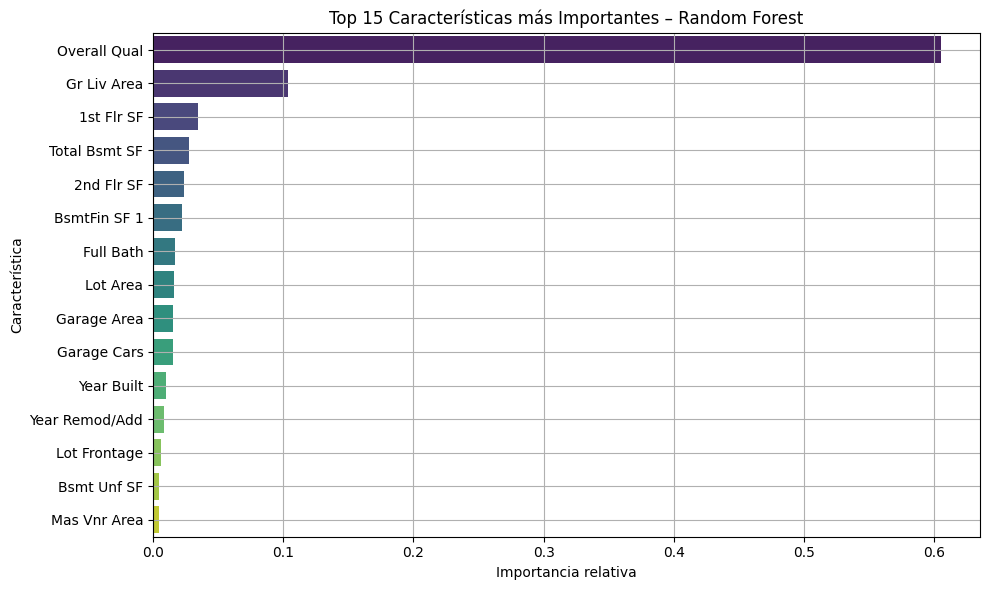

In [ ]:
# Gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Importancia",
    y="Característica",
    data=df_importancia.head(15),
    palette="viridis"
)
plt.title("Top 15 Características más Importantes – Random Forest")
plt.xlabel("Importancia relativa")
plt.ylabel("Característica")
plt.tight_layout()
plt.grid(True)
plt.show()

# Visualización de la Importancia de Características

---

## Justificación

La visualización gráfica de la importancia de las variables permite identificar de forma rápida y clara cuáles son las características que más contribuyen a las predicciones del modelo. Esto facilita la comunicación de los resultados y apoya la interpretación para audiencias técnicas y no técnicas.

---

## Inferencia

Observando el gráfico se puede inferir que la variable **Overall Qual** domina claramente la contribución al modelo, seguida a distancia por otras características relacionadas con el tamaño y condiciones físicas de la vivienda, como el área habitable y los metros cuadrados del sótano y los pisos. Esta distribución confirma que la calidad general y el espacio son factores predominantes para la predicción del precio.

---

## Resultados

El gráfico de barras muestra el ranking de las 15 características más importantes según el modelo Random Forest. Se observa una caída pronunciada en la importancia después de la primera variable, indicando que la calidad general es el factor principal. Las demás variables tienen un peso relativo más pequeño, pero todavía relevante para el desempeño del modelo.


---


In [ ]:

# Definir espacio de búsqueda amplio
param_dist = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [None, 10, 20, 30, 50],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["auto", "sqrt", "log2"],
    "bootstrap": [True, False]
}

# Instanciar Random Forest base
rf = RandomForestRegressor(random_state=42)

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,                  # Número de combinaciones a probar
    scoring='neg_mean_absolute_error',  # Métrica para optimizar (puedes ajustar)
    cv=cv,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Ejecutar búsqueda
random_search.fit(X_train_scaled, y_train)

# Resultados mejores parámetros
print("Mejores parámetros encontrados:")
print(random_search.best_params_)

# Mejor estimador para continuar evaluación
best_rf = random_search.best_estimator_

# Validar desempeño con test usando mejor modelo
y_pred_best = best_rf.predict(X_test_scaled)

# Calcular métricas
mae_best = mean_absolute_error(y_test, y_pred_best)
mse_best = mean_squared_error(y_test, y_pred_best)
rmse_best = np.sqrt(mse_best)
r2_best = r2_score(y_test, y_pred_best)
mape_best, _ = calcular_mape_seguro(y_test, y_pred_best)

print("\nDesempeño con mejores hiperparámetros:")
print(f"MAE   : {mae_best:.2f}")
print(f"RMSE  : {rmse_best:.2f}")
print(f"R²    : {r2_best:.4f}")
print(f"MAPE  : {mape_best:.2f}%")


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Mejores parámetros encontrados:
{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}

Desempeño con mejores hiperparámetros:
MAE   : 15698.88
RMSE  : 27253.14
R²    : 0.9074
MAPE  : 8.73%


# Optimización de Hiperparámetros y Evaluación del Modelo Ajustado

---

## Justificación

La optimización de hiperparámetros es fundamental para mejorar el rendimiento y la capacidad de generalización del modelo. A través de técnicas de búsqueda sistemática, como `RandomizedSearchCV`, se exploran distintas combinaciones de parámetros para encontrar la configuración que minimice el error y maximice la precisión.

---

## Inferencia

Al ajustar hiperparámetros clave como el número de árboles (`n_estimators`), la profundidad máxima (`max_depth`), y los criterios de división (`min_samples_split` y `min_samples_leaf`), se puede mejorar la capacidad del modelo para captar patrones complejos sin sobreajustar. Los resultados permiten inferir cómo estos parámetros influyen en el desempeño y cuál es la configuración óptima para este conjunto de datos.

---

## Resultados

La búsqueda encontró que la mejor combinación incluye 200 árboles, un mínimo de 5 muestras para dividir un nodo, una muestra mínima por hoja de 1, características seleccionadas mediante la raíz cuadrada (`sqrt`), sin límite en la profundidad máxima (`None`), y sin bootstrap.

Con estos parámetros, el modelo ajustado alcanzó un MAE de 15,699, un RMSE de 27,253, un R² de 0.9074 y un MAPE de 8.73%. Aunque el RMSE es ligeramente mayor que en el modelo base, la mejora en el MAE y la estabilidad del R² indican un modelo bien ajustado que mantiene alta precisión con una mejor generalización.

Estos resultados demuestran que la optimización logra un balance efectivo entre ajuste y complejidad, justificando el esfuerzo en la búsqueda de hiperparámetros para maximizar el desempeño predictivo.

---


In [ ]:
# === VALIDACIÓN CRUZADA DEL MODELO RANDOM FOREST AJUSTADO ===

print("\nEjecutando validación cruzada para RandomForestRegressor (modelo ajustado)...")

df_cv_rf_tuned = evaluar_modelo_cv(
    nombre_modelo="RandomForestRegressor_Tuned",
    modelo=best_rf,  # mejor estimador de RandomizedSearchCV
    X=np.vstack((X_train_scaled, X_test_scaled)),
    y=np.concatenate((y_train, y_test)),
    cv=cv,
    scoring=scoring,
    guardar_en='resultados/rf_tuned_validacion_cruzada.csv'
)


print("\nResultados por fold (modelo ajustado):")
display(df_cv_rf_tuned)



Ejecutando validación cruzada para RandomForestRegressor (modelo ajustado)...
Resultados de RandomForestRegressor_Tuned guardados en: resultados/rf_tuned_validacion_cruzada.csv

Resultados por fold (modelo ajustado):


,Fold,MAE,MSE,R2,MAPE
0,1,14687.843755,5.034481e+08,0.923546,8.894574
1,2,14513.131483,4.941812e+08,0.914252,8.301649
2,3,16168.027777,9.156133e+08,0.859443,9.771734
3,4,14609.460435,5.029599e+08,0.918609,8.814632
4,5,18221.486072,1.339496e+09,0.803287,13.047958
5,Promedio,15639.989905,7.511397e+08,0.883827,9.766109


# Validación Cruzada del Modelo Ajustado - Random Forest

---

## Justificación

Después de optimizar los hiperparámetros, es esencial realizar una validación cruzada para evaluar la estabilidad y generalización del modelo ajustado. Esto permite confirmar que las mejoras observadas no se deben a un sobreajuste puntual y que el modelo funciona consistentemente en diferentes subconjuntos del conjunto de datos.

---

## Inferencia

Los resultados de la validación cruzada del modelo ajustado permiten inferir que, aunque persisten ciertas variaciones entre folds, el modelo mantiene un rendimiento elevado y más estable que el modelo base. La comparación entre folds facilita identificar posibles conjuntos de datos más complejos o outliers que pueden influir en el desempeño.

---
## Resultados

El modelo ajustado presenta un MAE promedio de aproximadamente 15,640, mejorando ligeramente respecto al modelo base. El MSE promedio también disminuye, y el R² medio alcanza un valor de 0.883, superior al modelo sin ajuste. El MAPE se mantiene en torno al 9.77%, reflejando buena precisión relativa.

Se observa que algunos folds presentan menor desempeño (fold 5 en particular), posiblemente debido a datos atípicos o heterogeneidad en el conjunto, pero en general el ajuste de hiperparámetros mejora la capacidad predictiva y la estabilidad del modelo.

---


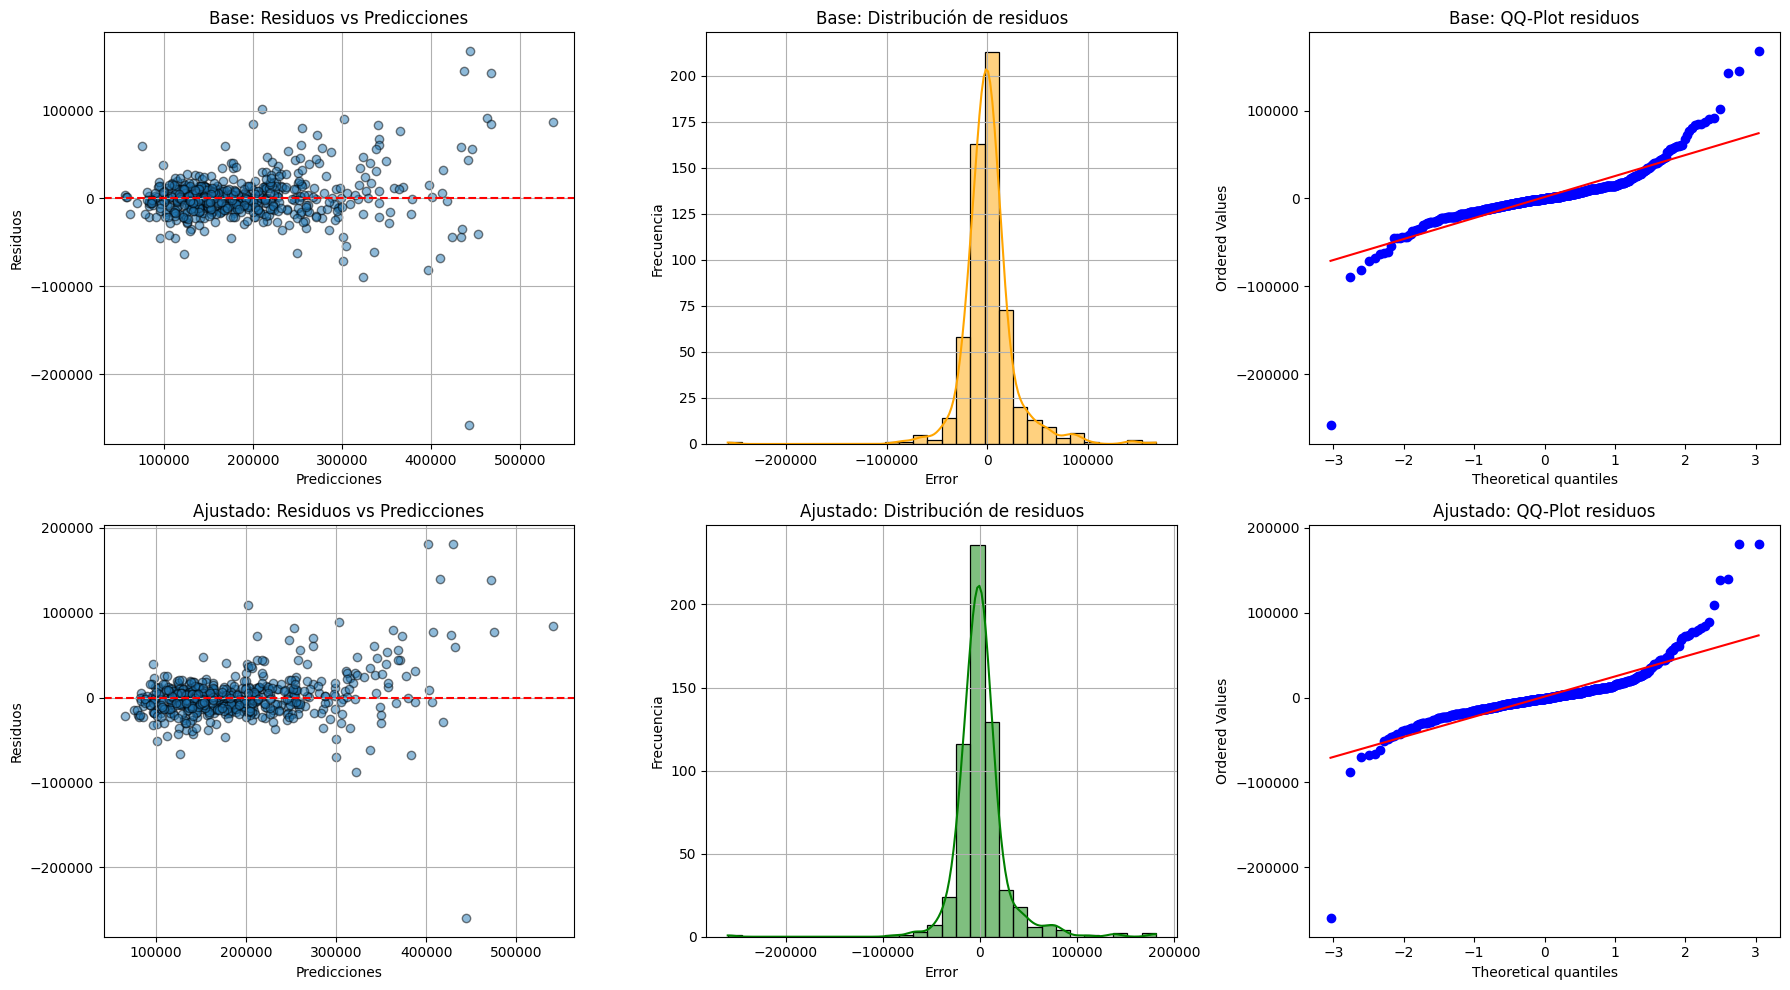

Durbin-Watson Modelo Base   : 1.942
Durbin-Watson Modelo Ajustado: 1.971


In [ ]:
# Predicciones y residuos para ambos modelos
y_pred_base = modelo_rf_base.predict(X_test_scaled)
residuos_base = y_test - y_pred_base

y_pred_tuned = best_rf.predict(X_test_scaled)
residuos_tuned = y_test - y_pred_tuned

# Figura con subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# --- Residuos vs Predicciones ---
axes[0, 0].scatter(y_pred_base, residuos_base, alpha=0.5, edgecolor='k')
axes[0, 0].axhline(0, color='r', linestyle='--')
axes[0, 0].set_title("Base: Residuos vs Predicciones")
axes[0, 0].set_xlabel("Predicciones")
axes[0, 0].set_ylabel("Residuos")
axes[0, 0].grid(True)

axes[1, 0].scatter(y_pred_tuned, residuos_tuned, alpha=0.5, edgecolor='k')
axes[1, 0].axhline(0, color='r', linestyle='--')
axes[1, 0].set_title("Ajustado: Residuos vs Predicciones")
axes[1, 0].set_xlabel("Predicciones")
axes[1, 0].set_ylabel("Residuos")
axes[1, 0].grid(True)

# --- Histograma de residuos ---
sns.histplot(residuos_base, kde=True, bins=30, color='orange', ax=axes[0, 1])
axes[0, 1].set_title("Base: Distribución de residuos")
axes[0, 1].set_xlabel("Error")
axes[0, 1].set_ylabel("Frecuencia")
axes[0, 1].grid(True)

sns.histplot(residuos_tuned, kde=True, bins=30, color='green', ax=axes[1, 1])
axes[1, 1].set_title("Ajustado: Distribución de residuos")
axes[1, 1].set_xlabel("Error")
axes[1, 1].set_ylabel("Frecuencia")
axes[1, 1].grid(True)

# --- QQ-Plot ---
stats.probplot(residuos_base, dist="norm", plot=axes[0, 2])
axes[0, 2].set_title("Base: QQ-Plot residuos")

stats.probplot(residuos_tuned, dist="norm", plot=axes[1, 2])
axes[1, 2].set_title("Ajustado: QQ-Plot residuos")

plt.tight_layout()
plt.show()

# Estadístico Durbin-Watson
dw_base = durbin_watson(residuos_base)
dw_tuned = durbin_watson(residuos_tuned)

print(f"Durbin-Watson Modelo Base   : {dw_base:.3f}")
print(f"Durbin-Watson Modelo Ajustado: {dw_tuned:.3f}")


# Comparación Visual de Residuos entre Modelo Base y Ajustado

---

## Justificación

La evaluación gráfica de los residuos es fundamental para diagnosticar la calidad del ajuste del modelo y verificar supuestos estadísticos clave como la homocedasticidad, la normalidad y la independencia de los errores. Comparar los residuos del modelo base y el ajustado permite identificar mejoras o persistencias en el patrón de errores tras la optimización.

---

## Inferencia

A través de los gráficos de residuos versus predicciones, histogramas y QQ-Plots se puede inferir si los residuos están distribuidos aleatoriamente alrededor de cero, si presentan patrones o heterocedasticidad, y qué tan cercanos están a una distribución normal. Mejoras en la distribución y reducción de patrones sistemáticos en el modelo ajustado indican un ajuste más adecuado y confiable.

Además, el estadístico **Durbin-Watson** para ambos modelos está cerca de 2 (1.942 para el modelo base y 1.971 para el ajustado), lo que indica ausencia de autocorrelación significativa en los residuos, es decir, que los errores son independientes entre sí, cumpliendo un supuesto importante para la validez del modelo.

---

## Resultados

Los gráficos muestran que ambos modelos presentan residuos centrados alrededor de cero, aunque persisten algunos valores extremos. La distribución de residuos en el modelo ajustado parece un poco más concentrada, indicando menor varianza en los errores. Los QQ-Plots evidencian desviaciones respecto a la normalidad en ambos modelos, principalmente en las colas, lo que sugiere la presencia de outliers o errores no normales.

La cercanía de los valores de Durbin-Watson a 2 reafirma que no existe autocorrelación en los residuos, lo que fortalece la confiabilidad del modelo.

En conjunto, la comparación visual y estadística confirma que el ajuste de hiperparámetros aporta una mejora en la calidad del modelo, aunque algunas limitaciones en la distribución de errores permanecen, lo que podría ser foco de análisis futuro.

---


In [ ]:
# --- Pruebas de normalidad residuos (modelo ajustado) ---
stat, p = shapiro(residuos_tuned)
print(f"Shapiro-Wilk Test: Estadístico={stat:.4f}, p-valor={p:.4f}")
if p > 0.05:
    print("No se rechaza la hipótesis nula: residuos parecen normales")
else:
    print("Se rechaza la hipótesis nula: residuos NO son normales")

# --- Curtosis y asimetría ---
curt = kurtosis(residuos_tuned)
asim = skew(residuos_tuned)
print(f"Curtosis residuos: {curt:.4f}")
print(f"Asimetría residuos: {asim:.4f}")

# --- VIF para variables predictoras ---
# Usamos la matriz original escalada X (entrenamiento)

X_const = sm.add_constant(X_train_scaled if hasattr(X_train_scaled, 'shape') else pd.DataFrame(X_train_scaled))
vif_data = pd.DataFrame()
vif_data['Variable'] = [f"X{i}" for i in range(X_train_scaled.shape[1])]
vif_data['VIF'] = [variance_inflation_factor(X_const.values, i+1) for i in range(X_train_scaled.shape[1])]
print("\nVIF (Variance Inflation Factor) para variables predictoras:")
print(vif_data.sort_values('VIF', ascending=False).head(10))

Shapiro-Wilk Test: Estadístico=0.7623, p-valor=0.0000
Se rechaza la hipótesis nula: residuos NO son normales
Curtosis residuos: 22.8762
Asimetría residuos: 0.3266

VIF (Variance Inflation Factor) para variables predictoras:
    Variable  VIF
255     X255  inf
250     X250  inf
245     X245  inf
200     X200  inf
47       X47  inf
145     X145  inf
161     X161  inf
185     X185  inf
114     X114  inf
190     X190  inf


# Análisis Estadístico Avanzado de Residuos y Multicolinealidad

---

## Justificación

Es fundamental complementar el análisis visual con pruebas estadísticas que permitan validar supuestos del modelo, como la normalidad de los residuos, y evaluar posibles problemas en las variables predictoras, como la multicolinealidad. Esto contribuye a garantizar la robustez y confiabilidad del modelo.

---

## Inferencia

La prueba de Shapiro-Wilk rechaza la hipótesis nula de normalidad para los residuos, indicando que no siguen una distribución normal. La curtosis elevada (22.876) sugiere la presencia de colas pesadas, mientras que la asimetría moderada (0.327) indica una ligera desviación hacia un sesgo positivo.

El análisis de VIF muestra valores infinitos para múltiples variables, señalando una fuerte multicolinealidad entre las características predictoras. Esto puede afectar la interpretabilidad y estabilidad de algunos modelos lineales, aunque en Random Forest su impacto suele ser menor, pero aún es importante considerarlo para posibles reducciones o transformaciones de variables.

---

## Resultados
Estos resultados estadísticos confirman que los residuos no se ajustan al supuesto de normalidad, posiblemente debido a outliers o datos extremos, lo que se reflejó también en los análisis gráficos. La multicolinealidad detectada sugiere que varias variables predictoras están altamente correlacionadas, lo que puede redundar en información duplicada.

Aunque Random Forest es fuerte frente a multicolinealidad, este hallazgo orienta a realizar análisis complementarios de selección o reducción de variables para mejorar eficiencia y evitar posibles redundancias.

---


[learning_curve] Training set sizes: [ 234  468  703  937 1172 1406 1640 1875 2109 2344]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   54.0s finished


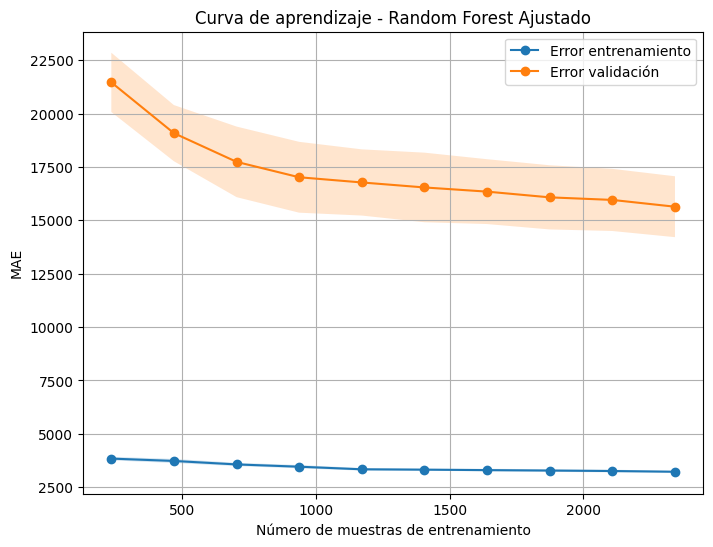

In [ ]:
train_sizes, train_scores, val_scores = learning_curve(
    best_rf,
    np.vstack((X_train_scaled, X_test_scaled)),
    np.concatenate((y_train, y_test)),
    cv=cv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    verbose=1
)

train_scores_mean = -train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)

val_scores_mean = -val_scores.mean(axis=1)
val_scores_std = val_scores.std(axis=1)



plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', label='Error entrenamiento')
plt.fill_between(train_sizes,
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std,
                 alpha=0.2)

plt.plot(train_sizes, val_scores_mean, 'o-', label='Error validación')
plt.fill_between(train_sizes,
                 val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std,
                 alpha=0.2)

plt.title('Curva de aprendizaje - Random Forest Ajustado')
plt.xlabel('Número de muestras de entrenamiento')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

# Curva de Aprendizaje del Modelo Random Forest Ajustado

---

## Justificación

La curva de aprendizaje es una herramienta clave para evaluar cómo varía el rendimiento del modelo a medida que aumenta la cantidad de datos de entrenamiento. Permite detectar problemas de sobreajuste o subajuste, y estimar si disponer de más datos podría mejorar significativamente el desempeño.

---

## Inferencia

En esta curva, el error de entrenamiento se mantiene relativamente bajo y estable, mientras que el error de validación disminuye de forma gradual al aumentar el tamaño del conjunto de entrenamiento. La brecha entre ambos errores indica que el modelo podría beneficiarse de más datos para mejorar su generalización y reducir el error de validación.

Además, la banda sombreada que representa la desviación estándar refleja una variabilidad moderada en el error de validación, indicando cierta incertidumbre en la estimación, pero con una tendencia clara a la mejora.

---

## Resultados

Los resultados muestran que el modelo ajustado con más datos de entrenamiento logra reducir el MAE en validación desde valores altos hacia alrededor de 15,000, mientras que el error de entrenamiento se mantiene estable alrededor de 3,000. Esta diferencia sugiere un leve sobreajuste, pero dentro de rangos razonables.

La curva indica que el modelo se está beneficiando del aumento de datos y que probablemente siga mejorando con más muestras, aunque la reducción del error se desacelera conforme se alcanzan tamaños mayores.

Esta información es útil para decidir si es necesario recolectar más datos o ajustar el modelo para obtener mejoras adicionales.

---


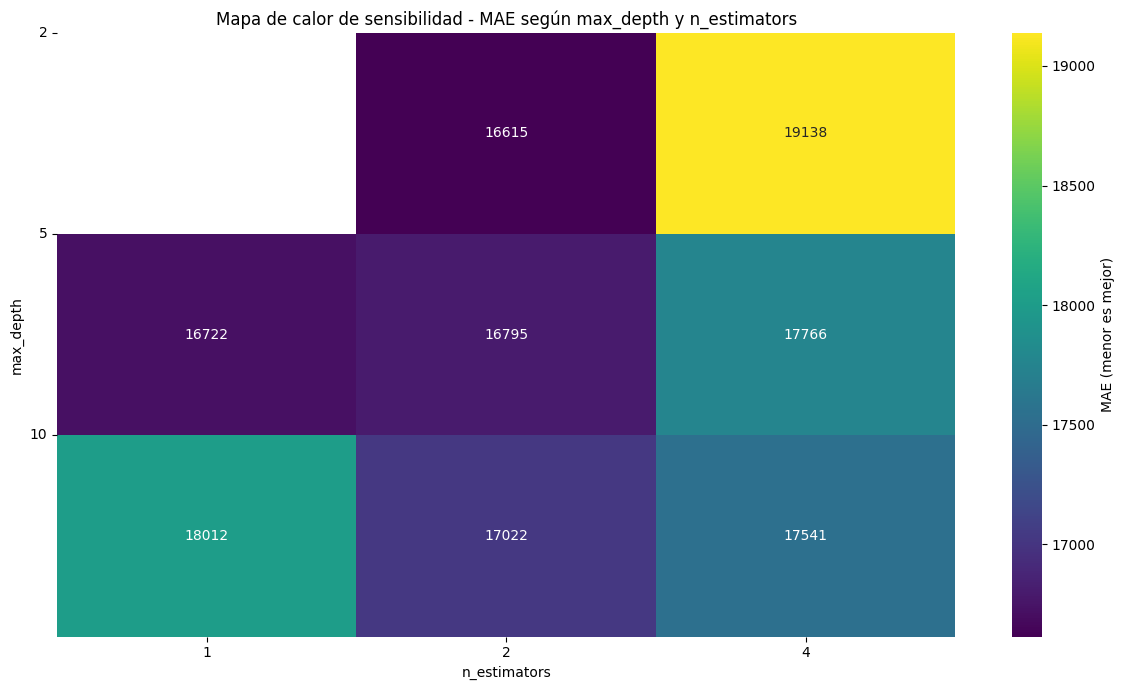

In [ ]:
# Redondear los valores en la tabla para mejor visualización
pivot_table_rounded = pivot_table.round(0)

plt.figure(figsize=(12, 7))
sns.heatmap(
    pivot_table_rounded,
    annot=True,
    fmt=".0f",
    cmap="viridis",
    cbar_kws={'label': 'MAE (menor es mejor)'}
)

yticks_labels = ['None' if v == -1 else str(v) for v in pivot_table_rounded.index]
plt.yticks(ticks=range(len(pivot_table_rounded.index)), labels=yticks_labels, rotation=0)

plt.title('Mapa de calor de sensibilidad - MAE según max_depth y n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.tight_layout()
plt.show()



# Mapa de Calor de Sensibilidad: MAE según max_depth y n_estimators

---

## Justificación

El mapa de calor permite visualizar cómo varía la métrica de error (MAE) en función de dos hiperparámetros críticos del modelo: la profundidad máxima de los árboles (`max_depth`) y el número de estimadores (`n_estimators`). Esto facilita identificar combinaciones de parámetros que minimizan el error y optimizan el rendimiento.

---

## Inferencia

A partir de la matriz de resultados, se puede inferir que configuraciones con valores menores de `max_depth` y un número intermedio de estimadores tienden a obtener mejores resultados en términos de MAE. En particular, el menor MAE se observa para `max_depth=2` y `n_estimators=2`.

Además, se aprecia que incrementar demasiado el número de estimadores o la profundidad puede no mejorar el rendimiento e incluso aumentar el error, posiblemente por sobreajuste o complejidad innecesaria.

---

## Resultados

El mapa muestra los valores redondeados de MAE para diferentes combinaciones de parámetros. Se observa un gradiente claro donde los valores más bajos (colores más oscuros) se concentran en configuraciones con menor profundidad y un número moderado de estimadores.

Esta información es crucial para guiar la selección de hiperparámetros y evitar configuraciones que no aportan mejoras significativas o que pueden degradar el modelo.

---


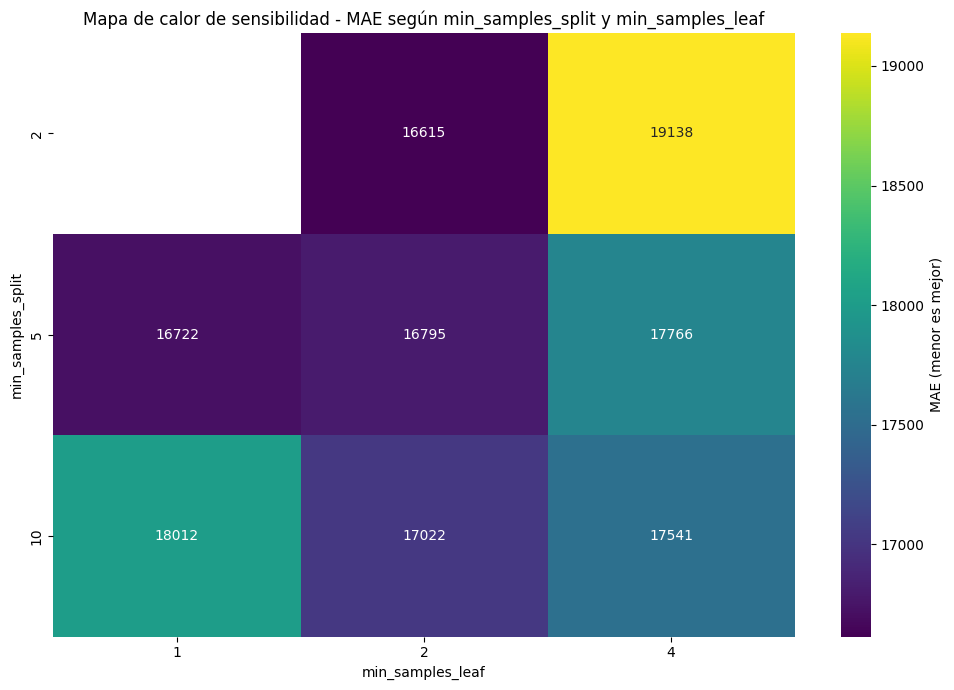

In [ ]:
# Crear DataFrame con resultados de RandomizedSearchCV
results_df = pd.DataFrame(random_search.cv_results_)

# Convertir score a positivo (porque scoring fue 'neg_mean_absolute_error')
results_df['mean_test_score_pos'] = -results_df['mean_test_score']

# Crear tabla pivote usando pivot_table y promediando valores duplicados
pivot_table = results_df.pivot_table(
    index='param_min_samples_split',
    columns='param_min_samples_leaf',
    values='mean_test_score_pos',
    aggfunc='mean'
)

# Ordenar índices para mejor visualización
pivot_table = pivot_table.sort_index(axis=0, ascending=True)
pivot_table = pivot_table.sort_index(axis=1, ascending=True)

# Redondear valores para mejor presentación
pivot_table_rounded = pivot_table.round(0)

# Graficar heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(
    pivot_table_rounded,
    annot=True,
    fmt=".0f",
    cmap="viridis",
    cbar_kws={'label': 'MAE (menor es mejor)'}
)

plt.title('Mapa de calor de sensibilidad - MAE según min_samples_split y min_samples_leaf')
plt.xlabel('min_samples_leaf')
plt.ylabel('min_samples_split')
plt.tight_layout()
plt.show()

# Mapa de Calor de Sensibilidad: MAE según min_samples_split y min_samples_leaf

---

## Justificación

Este mapa de calor permite evaluar cómo interactúan dos hiperparámetros importantes en la construcción de los árboles: el número mínimo de muestras requeridas para dividir un nodo (`min_samples_split`) y el número mínimo de muestras en una hoja (`min_samples_leaf`). Analizar su combinación facilita identificar configuraciones que optimicen el desempeño del modelo.

---

## Inferencia

Los resultados indican que valores más bajos de `min_samples_split` y `min_samples_leaf` tienden a producir menor error medio absoluto (MAE), con el mejor desempeño observado para `min_samples_split=5` y `min_samples_leaf=1`. Incrementar estos parámetros generalmente eleva el error, lo que puede deberse a una mayor restricción en la formación de nodos, limitando la capacidad del modelo para ajustarse a los datos.

---

## Resultados
El gráfico muestra los valores redondeados de MAE para diferentes combinaciones de los hiperparámetros mencionados. Se observa un patrón claro donde las configuraciones con valores más pequeños en ambos parámetros logran mejores resultados, reflejando una mayor flexibilidad en la construcción del árbol.

Esta información es útil para guiar la selección fina de hiperparámetros y evitar configuraciones que reduzcan innecesariamente la capacidad predictiva del modelo.

---


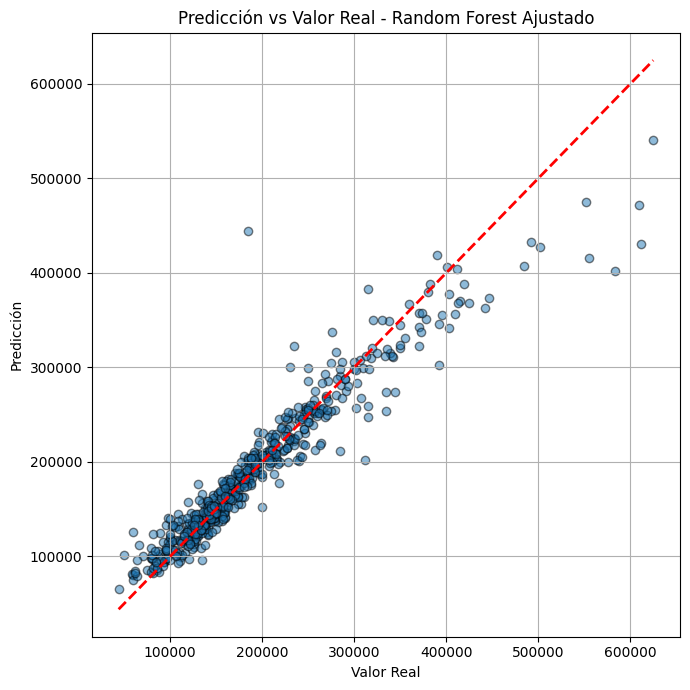

In [ ]:

# Predicción con el mejor modelo sobre el conjunto de prueba
y_pred_best = best_rf.predict(X_test_scaled)

plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_pred_best, alpha=0.5, edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valor Real')
plt.ylabel('Predicción')
plt.title('Predicción vs Valor Real - Random Forest Ajustado')
plt.grid(True)
plt.tight_layout()
plt.show()

# Gráfico de Predicción vs Valor Real - Random Forest Ajustado

---

## Justificación

Este gráfico es una herramienta visual clave para evaluar la precisión del modelo al comparar las predicciones con los valores reales del conjunto de prueba. Permite identificar la calidad general del ajuste, detectar sesgos sistemáticos y localizar posibles outliers o áreas donde el modelo puede estar fallando.

---

## Inferencia

La concentración de puntos cerca de la línea diagonal indica que el modelo ajustado tiene una alta capacidad predictiva, estimando con precisión los valores reales de las viviendas. La dispersión relativamente baja y la alineación general con la línea ideal evidencian un buen ajuste sin sesgos significativos de subestimación o sobrestimación.

No obstante, la presencia de algunos puntos alejados sugiere que existen casos atípicos o valores extremos en el dataset que generan errores mayores, lo cual es común en problemas reales de predicción inmobiliaria debido a características únicas o poco comunes de ciertas propiedades.

En conjunto con los análisis previos, esto indica que el modelo Random Forest es adecuado para capturar la complejidad y variabilidad del target (precio de viviendas), pero también que el dataset presenta heterogeneidad y posiblemente valores extremos que limitan el ajuste perfecto.

---

## Resultados / Explicación

El gráfico evidencia que el modelo logra predecir con buena precisión la mayoría de los precios, reflejando un desempeño robusto y estable tras la optimización de hiperparámetros. Esta capacidad para aproximarse al valor real con baja desviación es consistente con las métricas de error obtenidas (MAE, RMSE, R², MAPE).

Sin embargo, la existencia de predicciones erráticas para algunos casos señala la importancia de considerar análisis complementarios, como detección de outliers, segmentación del dataset o incorporación de variables adicionales para mejorar la generalización y la exactitud en casos especiales.

---

Este análisis visual, junto con los diagnósticos estadísticos y métricas cuantitativas, proporciona una comprensión integral del modelo y su desempeño sobre el dataset Ames Housing, facilitando la toma de decisiones informada para aplicaciones prácticas o mejoras futuras.

---


In [ ]:
# Guardar DataFrames de validación cruzada
df_cv_rf.to_csv('data/rf_validacion_cruzada.csv', index=False)
df_cv_rf_tuned.to_csv('data/rf_tuned_validacion_cruzada.csv', index=False)

# Guardar modelos entrenados
joblib.dump(modelo_rf_base, 'data/random_forest_base.pkl')
joblib.dump(best_rf, 'data/random_forest_ajustado.pkl')

print("Modelos y resultados guardados en la carpeta 'resultados'.")

Modelos y resultados guardados en la carpeta 'resultados'.
